<a href="https://colab.research.google.com/github/alankritmishra/DL-Notebooks/blob/master/Emotion_recognition_deepfeature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Winter2021erm/DeepLearning'

/content/drive/MyDrive/Winter2021erm/DeepLearning


#Import Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from numpy.linalg import svd
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import style
style.use('ggplot')

import numpy as np

from time import process_time

import tensorflow as tf
import tensorflow.keras as tfkeras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling1D, Conv1D, BatchNormalization
from tensorflow.keras.utils import to_categorical




# Data Load and pre-processing

In [ ]:
start_tm = process_time()

import load_data
BATCH_SIZE = 84420
# return DataSet class
data = load_data.read_data_sets(one_hot=True)

# get train data and labels by batch size
train_x, train_label = data.train.next_batch(BATCH_SIZE)


# get test data
test_x = data.test.data

# get test labels
test_labels = data.test.labels

# get sample number
n_samples = data.train.num_examples

In [ ]:
# checking the class balance
class_labels = np.argmax(train_label, axis=1) 
tr_x = data.test.data
ytr = class_labels[:,np.newaxis]
class_labels1 = np.argmax(test_labels, axis=1) 
ytr1 = class_labels1[:,np.newaxis]
X_tr, Y_tr = shuffle(tr_x, ytr1)

print((class_labels == 0).sum(), (class_labels == 1).sum(), (class_labels == 2).sum())


28602 26628 29190


In [ ]:
df = pd.DataFrame(train_x)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309
0,26.949333,26.949424,26.861163,26.812162,26.661981,27.587696,26.549262,25.758585,25.385482,25.145623,26.198452,26.034445,26.326324,26.969994,27.127615,26.012504,25.011290,24.595519,24.577834,25.364522,25.591049,25.937593,26.289821,26.257770,25.880814,25.132988,24.166483,23.905418,24.578191,24.948251,25.831181,26.269122,25.757270,25.478638,24.382872,24.264060,14.987302,24.332862,24.848300,25.583774,...,18.308116,20.297159,17.425524,16.694447,15.136893,14.572776,15.357469,16.031505,18.086168,21.001091,18.841674,16.626454,15.890106,15.528061,10.917773,15.877570,16.142808,17.145016,20.091993,16.995009,15.850987,15.950178,15.292737,14.700815,15.131632,16.087788,16.114655,17.560181,17.192433,16.354845,16.372776,16.697617,16.293963,16.865281,16.873584,16.944929,16.942522,16.220325,17.532951,17.530754
1,26.955406,26.955613,26.868182,26.818044,26.666225,27.587922,26.551130,25.762481,25.389843,25.148903,26.205186,26.040696,26.329236,26.968158,27.131471,26.016051,25.013175,24.601358,24.586097,25.370965,25.600188,25.938497,26.287435,26.257875,25.882855,25.144172,24.171383,23.906256,24.579484,24.954723,25.837816,26.271597,25.758647,25.480903,24.385948,24.271371,14.985875,24.337789,24.851200,25.588234,...,18.308370,20.296077,17.425212,16.696292,15.136792,14.572726,15.356948,16.032044,18.087191,21.000804,18.841397,16.626641,15.890714,15.530171,10.917998,15.878353,16.143662,17.145932,20.091365,16.995420,15.851106,15.951460,15.294437,14.701632,15.132245,16.089142,16.114575,17.560343,17.192295,16.354210,16.372439,16.698556,16.294541,16.866109,16.874401,16.943496,16.941230,16.220772,17.534059,17.531861
2,26.963946,26.963541,26.874687,26.825460,26.674357,27.589163,26.553955,25.767042,25.394798,25.153936,26.213907,26.049661,26.333780,26.967881,27.134772,26.019040,25.014697,24.609417,24.594678,25.376591,25.609558,25.942827,26.286761,26.257010,25.883496,25.156189,24.179172,23.910661,24.584093,24.963053,25.847131,26.275846,25.758523,25.482201,24.389576,24.279459,14.985330,24.342050,24.852295,25.592258,...,18.307648,20.295505,17.425471,16.697647,15.136607,14.572767,15.357243,16.032269,18.087642,21.000447,18.841623,16.626976,15.892359,15.532995,10.919123,15.878971,16.144709,17.146572,20.090851,16.996372,15.851705,15.953004,15.296113,14.703562,15.133191,16.090487,16.114152,17.560408,17.192854,16.354317,16.372793,16.699437,16.294608,16.866684,16.874944,16.942991,16.940950,16.221626,17.535703,17.533473
3,26.967221,26.966363,26.875835,26.827366,26.677842,27.586802,26.551150,25.765474,25.393453,25.151981,26.216844,26.052766,26.333052,26.963298,27.133008,26.016318,25.009613,24.610124,24.595780,25.375361,25.612559,25.941526,26.281289,26.250498,25.878242,25.161225,24.179255,23.907202,24.581595,24.964390,25.850373,26.274686,25.752630,25.477548,24.385657,24.279798,14.984342,24.338881,24.846147,25.590673,...,18.305193,20.294870,17.423888,16.696550,15.132624,14.568332,15.353745,16.029386,18.086579,20.999873,18.840251,16.624424,15.890634,15.532312,10.920850,15.876168,16.142705,17.144479,20.089370,16.994683,15.848884,15.951265,15.293805,14.698694,15.130040,16.088503,16.110337,17.558667,17.190805,16.351367,16.370303,16.697375,16.291537,16.864647,16.872895,16.939872,16.938002,16.219424,17.535556,17.533338
4,26.966336,26.965151,26.872804,26.825097,26.677364,27.582565,26.543586,25.758965,25.386850,25.144255,26.214773,26.051403,26.327814,26.954540,27.126797,26.009255,24.999227,24.604697,24.590590,25.368564,25.610279,25.935656,26.271268,26.239038,25.868024,25.160653,24.173228,23.897814,24.573911,24.959562,25.848221,26.268296,25.741799,25.467961,24.375317,24.273663,14.983310,24.329348,24.833939,25.584742,...,18.303353,20.294532,17.422693,16.696441,15.128639,14.563889,15.350433,16.026907,18.085511,20.99

In [ ]:
# Checking missing values
df.isnull().sum()
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
305    0
306    0
307    0
308    0
309    0
Length: 310, dtype: int64

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309
count,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,...,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000,84420.000000
mean,26.396527,26.360128,26.419866,25.601605,25.671509,26.919763,25.918811,25.154324,24.662018,24.626497,24.969076,24.958958,25.646313,26.333026,26.140911,25.450894,24.613766,24.202836,23.916911,24.350208,24.560698,25.228351,25.934871,25.714709,25.162459,24.317485,23.587443,20.799674,23.598439,24.319709,24.915007,25.555971,25.637335,24.926371,24.230328,23.585371,18.868834,23.892511,24.604421,25.060655,...,18.644518,19.156644,17.519090,16.026601,14.764468,13.100518,14.553300,15.859038,17.151676,19.010124,18.119943,16.743009,15.421123,14.392024,12.485169,14.462362,15.478896,16.640164,17.734316,17.537007,16.987886,15.826220,16.360705,14.653288,15.054164,15.846422,16.434099,17.258446,17.255989,17.033082,16.935305,15.957075,16.533977,17.486569,17.300625,17.304417,17.120621,16.717748,16.917112,17.044936
std,1.103073,1.150004,1.056542,1.020714,2.544231,1.178496,1.013131,1.060672,1.053496,1.031239,2.037447,0.948841,0.880570,0.964157,0.812964,1.385672,1.026480,1.270097,1.634479,2.552166,0.999569,0.960906,0.925091,0.840661,0.919848,1.040901,1.810560,3.834775,1.362437,1.039999,0.993560,0.904427,1.063671,1.027224,1.158672,1.279659,4.143314,1.447526,1.250235,1.528260,...,1.698299,2.090243,1.644950,1.293194,1.428045,1.324688,0.882693,1.223631,1.668595,2.117364,1.469283,1.259291,1.036264,0.818999,1.307971,0.966405,0.955619,1.851845,1.534383,1.441249,2.490883,1.128384,3.548640,0.952074,0.669244,0.875048,0.974583,1.180416,1.286608,1.181634,2.785451,1.273802,0.990676,3.008592,1.210701,1.035376,1.151189,0.926305,0.955995,1.120180
min,23.593029,23.589683,23.702490,23.136211,15.395556,23.496167,22.886468,22.294359,22.040103,22.154062,21.967373,22.508552,23.259618,23.485823,23.654661,22.497838,21.736455,21.483517,16.291388,21.033847,22.115722,22.554470,23.259946,23.608114,22.993486,21.767172,16.563067,13.867023,19.896116,21.509445,22.278489,22.917598,23.387973,21.907466,21.477733,20.603640,13.792385,20.116916,21.315213,22.355874,...,15.458954,15.109727,14.786195,13.883530,12.782701,10.649694,12.819083,13.437274,14.334913,15.103688,15.288140,14.419536,13.532396,12.604661,10.567627,12.213723,13.231141,14.080019,14.896303,15.072318,14.649558,13.929069,11.363637,11.210861,12.921659,13.866875,14.444929,14.917918,14.643894,14.429566,14.326281,14.053316,14.125926,14.147710,14.910260,15.342933,14.859121,14.926953,14.751540,12.914611
25%,25.643222,25.516163,25.690632,24.883402,24.781214,26.017342,25.202921,24.434915,23.923677,23.936937,23.941738,24.281036,25.043403,25.689613,25.563507,24.697847,23.894345,23.300705,23.195215,23.191574,23.848066,24.587452,25.299183,25.136764,24.492880,23.555748,22.461547,16.390811,22.706674,23.623525,24.174422,24.941075,24.910

In [ ]:
# Processing the raw data with standard scalar
stdsc = StandardScaler()
X_train = stdsc.fit_transform(train_x)
X_test = stdsc.transform(test_x)
X_tr = stdsc.transform(X_tr)

In [ ]:
print('Shape of X_Train : ', X_train.shape)
print('Shape of Train class : ', train_label.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of Test class : ', test_labels.shape)

loadtime = process_time() - start_tm

Shape of X_Train :  (84420, 310)
Shape of Train class :  (84420, 3)
Shape of X_test :  (58128, 310)
Shape of Test class :  (58128, 3)


### **DATA AUGMENTATION**

In [ ]:
start_aug = process_time()
df_aug = pd.DataFrame(X_tr)

In [ ]:
X_aug = np.copy(X_tr)
stand_dev = []

for i in range(len(df_aug.columns)):
    col = df_aug[i]
    stand_dev.append(np.std(col))

In [ ]:
aug_instances = 51212
for _ in range(1):
    for i in range(aug_instances):
        for j in range(len(df_aug.columns)): 
            X_aug[i,j] = X_aug[i,j] + np.random.uniform(stand_dev[j])

print("number of augmented instances: ", aug_instances)

number of augmented instances:  51212


In [ ]:
temp_df = pd.DataFrame(X_aug)

In [ ]:
X_train = np.concatenate((X_train, X_aug[0:aug_instances,:]), axis=0)
class_labels = np.concatenate((class_labels, Y_tr[0:aug_instances,:].ravel()), axis=0)
print('Shape of X_Train : ', X_train.shape)
print('Shape of Train class : ', class_labels.shape)

Shape of X_Train :  (135632, 310)
Shape of Train class :  (135632,)


In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(class_labels.reshape(-1,1))
train_label = onehot_encoded

In [ ]:
print('Shape of Train class : ', train_label.shape)

Aug_time = process_time() - start_aug

Shape of Train class :  (135632, 3)


## PCA decomposition

In [ ]:
pca = decomposition.PCA(n_components=0.9, random_state=3)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)

The PCA plot shows that the features a almost separable. So, we can use linearly separable functions.

Now we will find the variance spread of data in the range of principal components

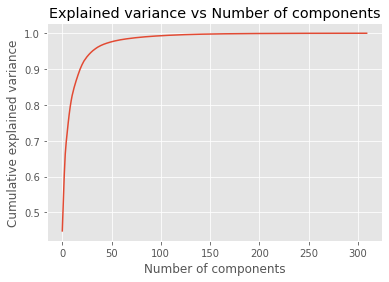

In [ ]:
pca_var = decomposition.PCA(n_components= 310)
X_pca = pca_var.fit_transform(X_train)
var_explained = pca_var.explained_variance_ratio_

cumulative_variance = np.cumsum(var_explained)
x = np.array(range(1,309))
plt.plot(cumulative_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
plt.show()

In [ ]:
# Finding the resultant dimension of PCs
principal_components = 0
for item in cumulative_variance:
    if item <= 0.99:
        principal_components += 1
print("Resultant PCA at variance of 99% is: {}".format(principal_components + 1))

Resultant PCA at variance of 99% is: 85


In [ ]:
start_tm = process_time()
pca_var = decomposition.PCA(n_components=85, random_state=3)

pca_training = pca_var.fit(X_train)

pca_training.explained_variance_
pca_training.n_components_
X_pca_train = pca_training.transform(X_train)
X_pca_test = pca_training.transform(X_test)

In [ ]:
X_pca_train.shape

(135632, 85)

# DCNN model

In [ ]:
relr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.01,
                                patience=2, min_lr=1e-5)
adam = tfkeras.optimizers.Adam()

In [ ]:
def moldel_maker() :

    model = tfkeras.Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="clf_input"))
    model.add(Dense(n_outputs, activation='softmax'))


    


    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()

    return model

## CNN deep feature extraction

Building the model

In [ ]:
start_featex = process_time()
epochs, batch_size = 15, 256
X_train_CNN = np.expand_dims(X_train, axis=2)
X_test_CNN = np.expand_dims(X_test, axis=2)
n_timesteps, n_features, n_outputs = X_train_CNN.shape[1], X_train_CNN.shape[2], train_label.shape[1]
X_train_CNN.shape

(135632, 310, 1)

In [ ]:
# shuffling the data before trianing
X_train_CNN, train_label = shuffle(X_train_CNN, train_label)
X_test_CNN, test_labels = shuffle(X_test_CNN, test_labels)

In [ ]:
model = moldel_maker()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 306, 32)           192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           14400     
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 9600)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2457856   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

### Training the model

In [ ]:
history = model.fit(X_train_CNN, train_label, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_CNN, test_labels),
                        callbacks=[relr])

Epoch 1/15
530/530 [==============================] - 22s 8ms/step - loss: 0.4678 - accuracy: 0.7849 - val_loss: 0.4445 - val_accuracy: 0.8772
Epoch 2/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0474 - accuracy: 0.9831 - val_loss: 0.5376 - val_accuracy: 0.8834
Epoch 3/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0254 - accuracy: 0.9912 - val_loss: 0.4569 - val_accuracy: 0.9075
Epoch 4/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.4385 - val_accuracy: 0.8977
Epoch 5/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.4131 - val_accuracy: 0.9142
Epoch 6/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.4500 - val_accuracy: 0.9101
Epoch 7/15
530/530 [==============================] - 4s 7ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.2880 - val_accuracy: 0.9249
Epoch

### Ploting graph

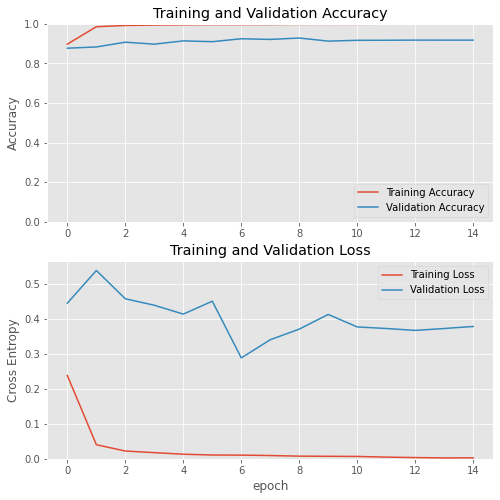

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Feature extraction

In [ ]:
print("\n EEG data - feature extraction\n")

model_feat = tfkeras.models.Model(inputs=model.input, outputs=model.get_layer('clf_input').output)

feat_train = model_feat.predict(X_train_CNN)
print("\nShape of train deep feature from CNN: ",feat_train.shape)

feat_test = model_feat.predict(X_test_CNN)
print("\nShape of test deep feature from CNN: ",feat_test.shape)


 EEG data - feature extraction


Shape of train deep feature from CNN:  (135632, 64)

Shape of test deep feature from CNN:  (58128, 64)


In [ ]:
y_train = np.argmax(train_label, axis=1) 
y_test = np.argmax(test_labels, axis=1)

featex_time = process_time() - start_featex

# Classificaion using Logistic Regression classifier

In [ ]:
start_logit = process_time()
logit = LogisticRegression(C=0.1)

# Training the model
logit.fit(feat_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Getting final test accuracy
print("Accuracy on Test set using Logistic Regression: ",logit.score(feat_test,y_test))

Logit_time = process_time() - start_logit

elapsed_tm = process_time() - start_tm

print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Time cost for Data loading and processing: %.2f sec" % (loadtime))     
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Time cost for Data Augmentation: %.2f sec" % (Aug_time))     
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Time cost for Feature Extraction: %.2f sec" % (featex_time))     
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Time cost for Classification: %.2f sec" % (Logit_time))     
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to run time program: %.2f min" % (elapsed_tm/60))     
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

Accuracy on Test set using Logistic Regression:  0.9191095513349848


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time cost for Data loading and processing: 3.66 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time cost for Data Augmentation: 46.30 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time cost for Feature Extraction: 94.54 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time cost for Classification: 12.77 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to run time program: 2.10 min
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

